In [17]:
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

In [18]:
STD = 1.0
N_SAMPLES = 100
N_CLUSTERS = 4
MAX_ITER = 1000

colors = 'bgrcmykw'
# Generate sample data
X, y = make_blobs(n_samples=N_SAMPLES, n_features=2, centers=N_CLUSTERS, cluster_std=STD, random_state=20)

# Sort data based on cluster labels
y_sorted = np.argsort(y)
X_sorted = np.zeros(X.shape)
for i in range(X.shape[0]):
    X_sorted[i, :] = X[y_sorted[i], :]

X, y = X_sorted, y[y_sorted]

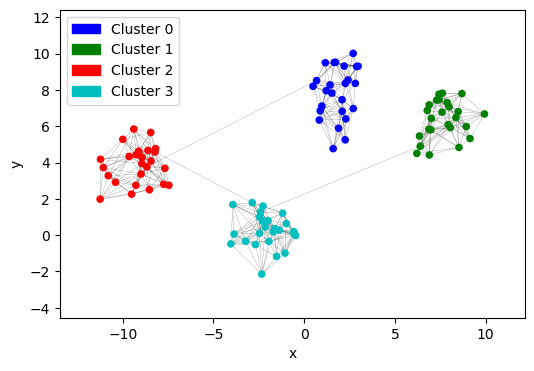

In [19]:
# Create graph
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', radius=STD).fit(X)
distances, indices = nbrs.kneighbors(X)

G = nx.Graph()
for i in range(X.shape[0]):
    for j in range(1, indices.shape[1]):
        G.add_edge(i, indices[i, j], weight=np.exp(-distances[i, j] / (2 * STD ** 2)))

# Add random edges to graph to increase connectivity
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if i != j and np.random.rand() < 0.001:
            G.add_edge(i, j, weight=np.exp(-np.linalg.norm(X[i, :] - X[j, :]) / (2 * STD ** 2)))

# Plot graph with nodes at sample data points
pos = {i: X[i, :] for i in range(X.shape[0])}

# plt.figure(figsize=(5, 5))
handles = []
for i in range(4):
    handles.append(mpatches.Patch(color=colors[i], label='Cluster %d' % i))
fig, ax = plt.subplots(figsize=(6, 4))
# Add axis labels
nx.draw(G, pos, node_size=20, width=0.1, node_color=[colors[y[node]] for node in G.nodes], ax=ax)
limits=plt.axis('on') # turns on axis
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.legend(handles=handles)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Calculate

/var/folders/xy/2r8t088s2pn_nrnl76p9tkv00000gn/T/ipykernel_35408/3586720541.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G, nodelist=np.arange(N_SAMPLES)).toarray()


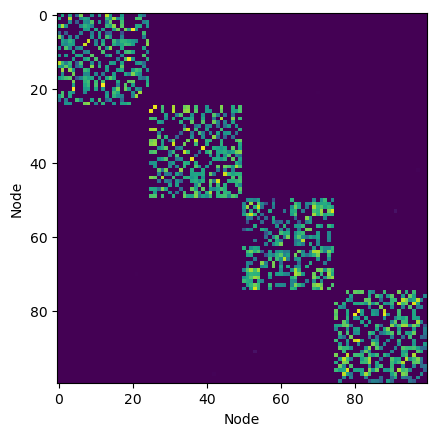

In [20]:
# Calculate adjacency matrix
W = nx.adjacency_matrix(G, nodelist=np.arange(N_SAMPLES)).toarray()
# W = W * (W > 0.2)

# Plot adjacency matrix
plt.imshow(W, cmap='viridis')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()


In [21]:
# Initialize data to be aggregated
s = [i for i in range(W.shape[0])]

# Calculate real aggregate
cluster_sum = [sum([s[i] for i in range(W.shape[0]) if y[i] == j]) for j in range(N_CLUSTERS)]
real_psi = np.array([cluster_sum[y[i]] for i in range(W.shape[0])])

def gaussian(x, mu, sigma):
    # return np.exp(-np.linalg.norm(x - mu) / (2 * sigma ** 2)) * (np.linalg.norm(x - mu) < 2 * sigma)
    return np.linalg.norm(x - mu) < 2 * sigma

In [22]:
eps_list = [10.]

error_history = []
omega_history = []
psi_history = []

for eps0 in eps_list:

    omega = X.copy()
    new_omega = X.copy()

    # Initialize contribution matrix
    phi = np.eye(W.shape[0])
    new_phi = np.eye(W.shape[0])

    # Initialize aggregate matrix
    psi = np.zeros((W.shape[0],))
    new_psi = np.zeros((W.shape[0],))

    phi_converged = False
    psi_converged = False

    error = []
    eps = eps0
    for iter in tqdm(range(300)):
        # Calculate new stationary distribution
        for i in range(W.shape[0]):
            # Calculate sum of W_ij * phi_j
            if not phi_converged:
                sum_omega = omega[i, :].copy()
                sum_phi = phi[i, :].copy()
            sum_psi = psi[i] + eps * (s[i] - phi[i, i] * psi[i])
            sum_W = 1.
            for j in G.neighbors(i):
                W_ij = gaussian(omega[i, :], omega[j, :], STD)
                if not phi_converged:
                    sum_phi += W_ij * phi[j, :]
                sum_omega += W_ij * omega[j, :]
                sum_psi += W_ij * psi[j]
                sum_W += W_ij
            if not phi_converged:
                new_phi[i, :] = sum_phi / sum_W
            new_omega[i, :] = sum_omega / sum_W
            new_psi[i] = sum_psi / sum_W

        # Check if stationary distribution has converged

        if not phi_converged:
            if np.linalg.norm(new_phi - phi) < 1e-15:
                print('Phi converged after {} iterations'.format(iter))
                phi_converged = True
            else:
                # print('%.6f' % np.linalg.norm(new_phi - phi))
                omega = new_omega.copy()
                phi = new_phi.copy()
        if iter > 0 and np.linalg.norm(new_psi - psi) < 1e-6:
            print('Psi converged after {} iterations'.format(iter))
            break
        else:
            psi = new_psi.copy()
            if phi_converged:
                eps = eps * 0.99

        error_history.append(np.linalg.norm(psi - real_psi))
        omega_history.append(omega.copy())
        psi_history.append(psi.copy())

 66%|██████▌   | 198/300 [00:01<00:00, 131.96it/s]

Phi converged after 165 iterations


100%|██████████| 300/300 [00:02<00:00, 130.13it/s]


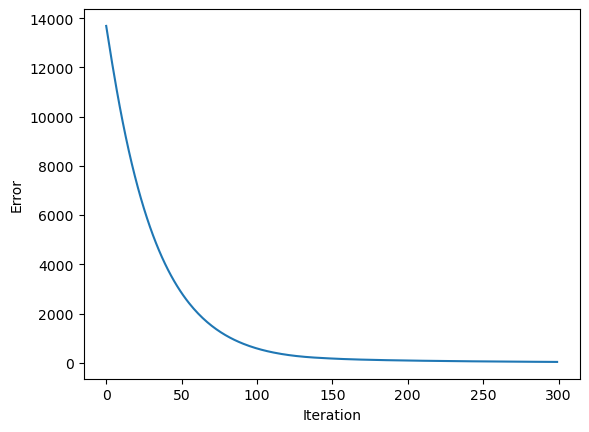

In [13]:
# Plot error history
plt.plot(error_history)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

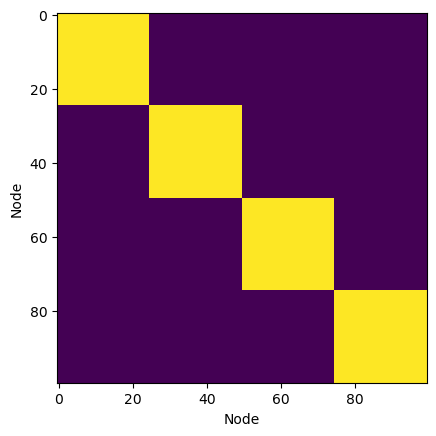

In [14]:
# Calculate trust matrix
V = np.zeros((W.shape[0], W.shape[0]))
for i in range(W.shape[0]):
    for j in range(W.shape[0]):
        V[i, j] = gaussian(omega[i, :], omega[j, :], STD)

# Plot trust matrix
plt.imshow(V, cmap='viridis')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

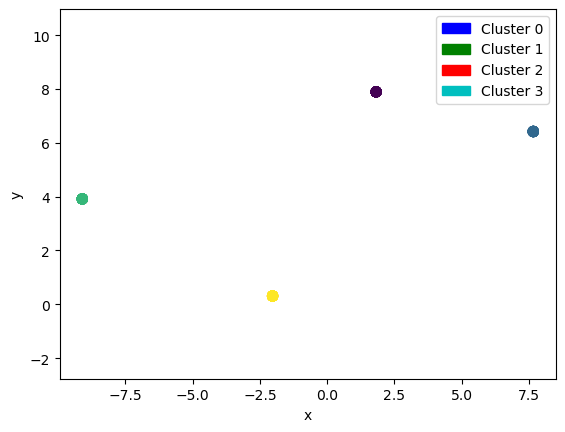

In [15]:
# Plot omega
plt.figsize=(6, 4)
plt.scatter(omega[:, 0], omega[:, 1], c=y, s=50, cmap='viridis')
plt.legend(handles=handles)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

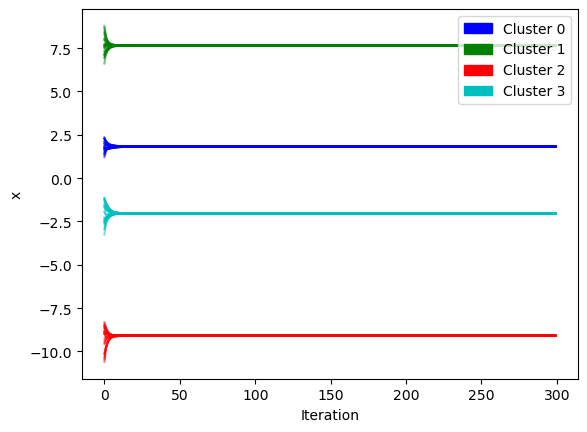

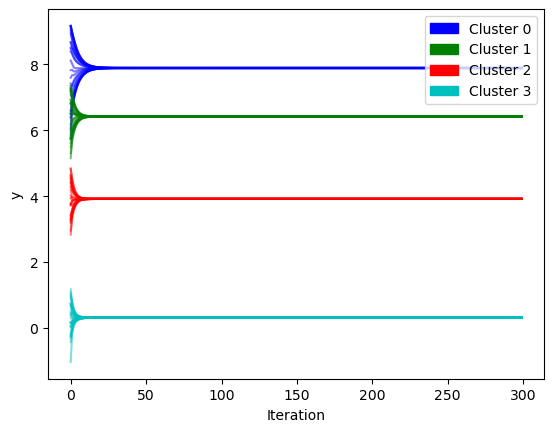

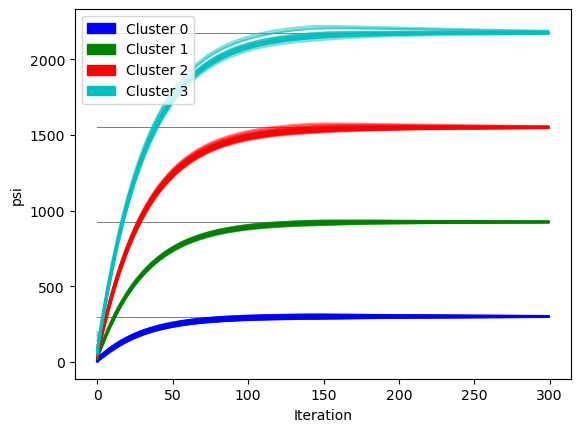

In [16]:
# Plot omega history from samples
for i in range(omega_history[0].shape[0]):
    plt.plot([omega_history[iter][i, 0] for iter in range(300)], c=colors[y[i]], alpha=0.5)
plt.legend(handles=handles)
plt.xlabel('Iteration')
plt.ylabel('x')
plt.show()
for i in range(omega_history[0].shape[0]):
    plt.plot([omega_history[iter][i, 1] for iter in range(300)], c=colors[y[i]], alpha=0.5)
plt.legend(handles=handles)
plt.xlabel('Iteration')
plt.ylabel('y')
plt.show()

# Plot all real psi
for i in range(psi_history[0].shape[0]):
    plt.plot([real_psi[i] for iter in range(300)], c='0.5', alpha=0.5, linestyle='-', linewidth=0.5)
# Plot psi history from samples
for i in range(psi_history[0].shape[0]):
    plt.plot([psi_history[iter][i] for iter in range(300)], c=colors[y[i]], alpha=0.5)

plt.legend(handles=handles)
plt.xlabel('Iteration')
plt.ylabel('psi')
plt.show()